In [75]:
from datasets import load_dataset;

In [76]:
#Getting the katanml/cord dataset
datasets = load_dataset("katanaml/cord");
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 800
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 100
    })
})

In [77]:
#Ini aku menjadi target
labels = datasets['train'].features['ner_tags'].feature.names
labels

['O',
 'I-menu.cnt',
 'I-menu.discountprice',
 'I-menu.nm',
 'I-menu.num',
 'I-menu.price',
 'I-menu.sub_cnt',
 'I-menu.sub_nm',
 'I-menu.sub_price',
 'I-menu.unitprice',
 'I-sub_total.discount_price',
 'I-sub_total.etc',
 'I-sub_total.service_price',
 'I-sub_total.subtotal_price',
 'I-sub_total.tax_price',
 'I-total.cashprice',
 'I-total.changeprice',
 'I-total.creditcardprice',
 'I-total.emoneyprice',
 'I-total.menuqty_cnt',
 'I-total.menutype_cnt',
 'I-total.total_etc',
 'I-total.total_price']

In [ ]:
from PIL import Image
image = Image.open('./receipt.jpg')
image = image.convert("RGB")
image

FileNotFoundError: [Errno 2] No such file or directory: '/Users/aldofebri/Documents/GitHub/sparrow/sparrow-data/model/reciept.jpg'

In [ ]:
words = ["BESALI","CAFE","BESALI CAFE","De Tjolomadoe","Colomadu, Karanganyar","Pax:2","TABLE:33","OP:","Endah","POS Title:KASIR","POS:POS001","Rcpt#:B18000000060","29/03/201819:29","1 Mie Goreng Jawa","30,000","Nasi Goreng Besali","35,000","1.","Pisang Goreng","15,000","1 Tahu Isi","12.000","1 Tempe Mendoan","10,000","7 Ice Tea","175,000","SUBTOTAL","277,000"]
bbox = [[323,12,611,87],[366,77,570,140],[363,187,540,245],[351,240,555,297],[285,325,616,390],[116,400,206,460],[385,380,510,427],[350,425,400,465],[566,420,655,475],[116,447,371,520],[596,467,761,512],[116,497,415,567],[506,517,765,560],[146,592,433,662],[663,605,765,660],[178,645,476,712],[665,650,765,705],[153,702,186,732],[180,695,400,755],[666,697,765,752],[145,742,320,795],[666,745,763,792],[146,795,403,847],[666,795,763,840],[145,837,306,900],[648,832,763,897],[181,937,318,992],[646,927,765,990]]
print(len(words), len(bbox))

23 23


In [ ]:
from transformers import LayoutLMv2Processor

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

encoded_inputs = processor(image, words, boxes=bbox, return_offsets_mapping=True, return_tensors="pt")
offset_mapping = encoded_inputs.pop('offset_mapping')

In [ ]:
encoded_inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for k,v in encoded_inputs.items():
  encoded_inputs[k] = v.to(device)
len(encoded_inputs)

5

In [ ]:
from transformers import LayoutLMv2ForTokenClassification

# load the fine-tuned model from the hub
model = LayoutLMv2ForTokenClassification.from_pretrained("katanaml/layoutlmv2-finetuned-cord")
id2label = model.config.id2label
model.to(device)

# forward pass
outputs = model(**encoded_inputs)
print(outputs.logits.shape)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


torch.Size([1, 70, 23])


In [ ]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoded_inputs.bbox.squeeze().tolist()

width, height = image.size

In [ ]:
processor.tokenizer.batch_decode(encoded_inputs.input_ids)

['[CLS] ferrari carano 47. 00 insalate cesare 7. 50 caprese with prosciutto 9. 50 fish spec 25. 95 spinach ricotta ravioli 15. 95 seafood pasta 19. 95 ossobucco 29. 95 sub total 155. 80 tax 14. 02 total 169. 82 balance due 169. 82 [SEP]']

In [ ]:
import numpy as np

is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

In [ ]:
true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
print(len(true_predictions))
true_predictions

25


['I-menu.nm',
 'I-menu.nm',
 'I-menu.price',
 'I-menu.nm',
 'I-menu.price',
 'I-menu.nm',
 'I-menu.price',
 'I-menu.nm',
 'I-menu.price',
 'I-menu.nm',
 'I-menu.price',
 'I-menu.nm',
 'I-menu.price',
 'I-menu.nm',
 'I-menu.price',
 'I-sub_total.subtotal_price',
 'I-sub_total.subtotal_price',
 'I-sub_total.tax_price',
 'I-sub_total.tax_price',
 'I-total.total_price',
 'I-total.total_price',
 'I-total.total_price',
 'I-total.total_price',
 'I-total.total_price',
 'I-menu.nm']

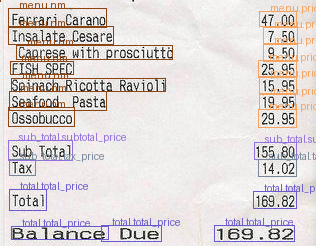

In [ ]:
from PIL import ImageDraw, ImageFont
import numpy as np
import PIL

draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'o'
    return label

label_ints = np.random.randint(0,len(PIL.ImageColor.colormap.items()),30)

label_color_pil = [k for k,_ in PIL.ImageColor.colormap.items()]
	
label_color = [label_color_pil[i] for i in label_ints]
label2color = {}
for k,v in id2label.items():
  if v[2:] == '':
    label2color['o']=label_color[k]
  else:
    label2color[v[2:]]=label_color[k]

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image